In [1]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models
from torch.utils.data import DataLoader
from peft import LoraConfig, get_peft_model, TaskType
import torch
from datasets import load_dataset
from tqdm import tqdm
import pickle
import random
from datasets import Dataset
import os
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch
import gc
from uuid import uuid4
import json
import numpy as np
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
config = {}

### Подготовка данных

##### Конфигурация данных

In [3]:
config['data'] = {'SYNT_TYPE': 'single',
                'POSITIVE_THRESHOLD': 83,
                'NEGATIVE_MINING_MARGINE': '001',
                'NUM_NEGATIVES': 1,
                'HARG_NEGATIVES_THRESHOLD': 75,
                'USE_ALL_DATA': True
                }

##### Загрузка данных

In [4]:
data_config = config['data']
soft_negatives = pickle.load(open(f'data/soft_negatives_{data_config['SYNT_TYPE']}_{data_config['POSITIVE_THRESHOLD']}_{data_config['NEGATIVE_MINING_MARGINE']}_{data_config['NUM_NEGATIVES']}_{data_config['HARG_NEGATIVES_THRESHOLD']}.pkl', 'rb'))
hard_negatives = pickle.load(open(f'data/hard_negatives_{data_config['SYNT_TYPE']}_{data_config['POSITIVE_THRESHOLD']}_{data_config['NEGATIVE_MINING_MARGINE']}_{data_config['NUM_NEGATIVES']}_{data_config['HARG_NEGATIVES_THRESHOLD']}.pkl', 'rb'))

if data_config['USE_ALL_DATA']:
    train_data = hard_negatives + soft_negatives
else:
    train_data = hard_negatives
    
random.shuffle(train_data)

train_dataset = Dataset.from_dict({
    'anchor': [data[0] for data in train_data],
    'positive': [data[1] for data in train_data],
    'negative': [data[2] for data in train_data],
})


##### Конфигурация LoRA

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config['LoRA'] = {
                    "MODEL_NAME": "e5_large",
                    "LORA_R": 16,
                    "LORA_ALPHA": 32,
                    "LORA_DP": 0.05
                }

LORA_CONFIG = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    inference_mode=False,
    r=config['LoRA']['LORA_R'],
    lora_alpha=config['LoRA']['LORA_ALPHA'],
    lora_dropout=config['LoRA']['LORA_DP'],
    bias="none",
    # modules_to_save=["pooling"]
)

In [6]:
model = SentenceTransformer(config['LoRA']['MODEL_NAME'], device=DEVICE)
before_num_params = sum(p.numel() for p in model.parameters())
model.add_adapter(LORA_CONFIG)
after_num_params = sum(p.numel() for p in model.parameters())
print('Параметров до добавления LoRA:', before_num_params)
print('Параметров после добавления LoRA:', after_num_params)
print('Всего обучаемых параметров:', after_num_params - before_num_params)


Параметров до добавления LoRA: 559890432
Параметров после добавления LoRA: 561463296
Всего обучаемых параметров: 1572864


##### Параметры обучения

In [7]:
config['training'] = {'LR': 2e-5,
                    'WEIGHT_DECAY': 0.01,
                    'MARGIN': 0.2,
                    'EPOCHS': 5,
                    # 'ALPHA': 0.1,
                    'BATCH_SIZE': 32,
                    'ACCUMULATION_STEPS': 1}

In [8]:
def prepare_batch_for_triplet_loss(batch):
    anchors, positives, negatives = batch['anchor'], batch['positive'], batch['negative']
    features = []
    for texts in [anchors, positives, negatives]:
        tokenized = model.tokenize(texts)
        tokenized = {key: value.to(model.device) for key, value in tokenized.items()}
        features.append({'input_ids': tokenized['input_ids'], 'attention_mask': tokenized['attention_mask']})
    return features

In [9]:
triplet_loss = losses.TripletLoss(model=model, distance_metric=losses.TripletDistanceMetric.EUCLIDEAN, triplet_margin=config['training']['MARGIN'])
cosine_loss = losses.CosineSimilarityLoss(model=model)


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=config['training']['BATCH_SIZE'], shuffle=True)


at_epoch: 0 
at_step: 479 / 692 
loss: 0.17867277562618256


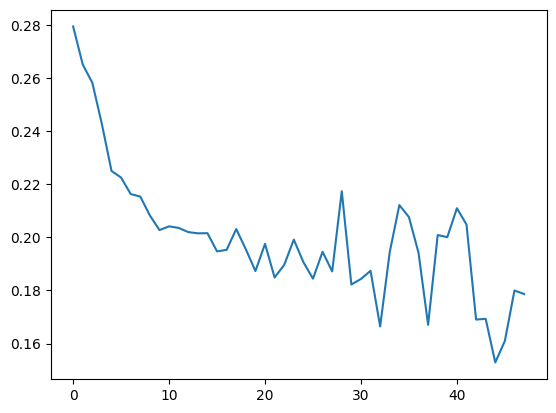

In [11]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['training']['LR'],
    weight_decay=config['training']['WEIGHT_DECAY']
)

log_interval = 10

model_save_path = f'lora_{str(uuid4())}'
    
losses = []
for epoch in range(config['training']['EPOCHS']):
    model.train()
    epoch_loss = 0.0
    cur_losses = []
    loss_value = 0
    for step, batch in enumerate(train_dataloader):
        if step % config['training']['ACCUMULATION_STEPS'] == 0:
            loss_value = triplet_loss(prepare_batch_for_triplet_loss(batch), None)
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
        else:
            loss_value = loss_value + triplet_loss(prepare_batch_for_triplet_loss(batch), None)
            
        current_loss = loss_value.item()
        del loss_value
        cur_losses.append(current_loss)
        if step % log_interval == log_interval - 1:
            clear_output()
            print('at_epoch:', epoch, '\nat_step:', step, '/', len(train_dataloader), '\nloss:', current_loss)
            losses.append(np.mean(current_loss))
            cur_losses = []
            plt.plot(losses)  
            plt.show()
    model_save_path = f'{model_save_path}/epoch_{epoch}'     
    os.makedirs(model_save_path, exist_ok=True)
    model.save(model_save_path)

with open(model_save_path + '/config.json', 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)
    